# Kickstarter Project

Allison Yan Cao, Constance McCarney, and Kyle Riener

In [1]:
# prepare the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.3f}'.format

In [3]:
# load dataframe
ks = pd.read_csv('ks-projects-201801.csv')

# Data Set Description

**Kickstarter** is an American public-benefit corporation based in Brooklyn, New York, that maintains a global crowdfunding platform focused on creativity. The company's stated mission is to "help bring creative projects to life". Kickstarter has reportedly received more than $1.9 billion in pledges from 9.4 million backers to fund 257,000 creative projects, such as films, music, stage shows, comics, journalism, video games, technology and food-related projects.

<li> The datasets contain kickstarter projects from 05/2009 to 01/2018.

##### Columns:
<ul>
<li> **name**: name of the ks project
<li> **category**: category of the ks project
<li> **main_category**: main category of the ks project
<li> **currency**: currency type of the pledges
<li> **deadline**: deadline date of the ks project
<li> **launched**: launch date of the ks project
<li> **state**: current status of the ks project
<li> **backers**: number of backers to the ks project
<li> **country**: country where the ks project based 
<li> **usd_pledged_real**: conversion in US dollars of the pledged amount
<li> **usd_goal_real**: conversion in US dollars of the goal amount
</ul>

In [4]:
ks.shape

(378661, 15)

In [5]:
# view first few lines of dataframe
ks.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,"1,000.000",2015-08-11 12:12:28,0.000,failed,0,GB,0.000,0.000,"1,533.950"
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,"30,000.000",2017-09-02 04:43:57,"2,421.000",failed,15,US,100.000,"2,421.000","30,000.000"


Here are the top countries with the most kickstarter campaigns and the total number of campaigns by status.

In [6]:
ks.groupby('country').size().sort_values(ascending=False).head()
ks.groupby('state').size().sort_values(ascending=False)

country
US    292627
GB     33672
CA     14756
AU      7839
DE      4171
dtype: int64

state
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
dtype: int64

We will be looking at the differences among only the top 3 countries, the US, Great Britain, and Canada. Since we are only interested in those campaigns that succeed or fail, we will drop those campaigns which end early, either because they are suspended or canceled, are still ongoing or are otherwise undefined. Also, this dataset helpfully already has converted the pledged and goal amounts into real US dollars so we can drop the extraneous amount columns.

In [7]:
ks.drop(ks[((ks.country == 'US') | (ks.country == 'GB') | (ks.country == 'CA')) == False].index, inplace=True)
ks.drop(ks[((ks.state == 'failed') | (ks.state == 'successful')) == False].index, inplace=True)
ks.drop(['pledged','goal','usd pledged','currency'], axis=1, inplace=True)
ks.dropna(inplace=True)

In [8]:
ks.shape

(303181, 11)

# Data Preparation

First we convert the date fields and extract their component time dimensions: day of the week (0-6), month (01-12), and hour (01-23). 

In [9]:
ks.loc[:,['deadline', 'launched']] = ks.loc[:,['deadline', 'launched']].apply(pd.to_datetime)
ks['launch_week_day'] = ks.launched.apply(lambda x: datetime.strftime(x,'%w')).astype(int)
ks['launch_month'] = ks.launched.apply(lambda x: datetime.strftime(x,'%m')).astype(int)
ks['launch_hour'] = ks.launched.apply(lambda x: datetime.strftime(x,'%H')).astype(int)

With this information preserved we can convert the launched column to datetime type again and then generate a new column, "duration," representing the length of campaign in days.

In [10]:
ks['launched'] = ks['launched'].dt.date
ks['launched'] = pd.to_datetime(ks['launched'])

ks['duration'] = ks['deadline'] - ks['launched']
ks['duration'] = ks['duration'].dt.days

Now we'll create a dummy variable to indicate the successful campaigns and organize the duration into a categorical.

In [11]:
ks['DurationBin'] = ks.duration.apply(lambda x: '30' if x==30 else '<30' if x<30 else '>30')

ks = pd.get_dummies(ks, columns=['state']).rename(columns=\
                {'state_successful':'success'}).drop(['state_failed'], axis=1)

Finally, we will create separate country specific datasets to make our analysis simpler.

In [12]:
us = ks[ks.country == 'US']
gb = ks[ks.country == 'GB']
ca = ks[ks.country == 'CA']
us.shape
gb.shape
ca.shape

(261358, 16)

(29453, 16)

(12370, 16)

# General Analysis

Let's take a look at the success rate per country and see which main categories perform strongest.

In [13]:
ks.groupby('country').success.mean().sort_values(ascending=False)

country
US                  0.418
GB                  0.410
CA                  0.334
Name: success, dtype: float64

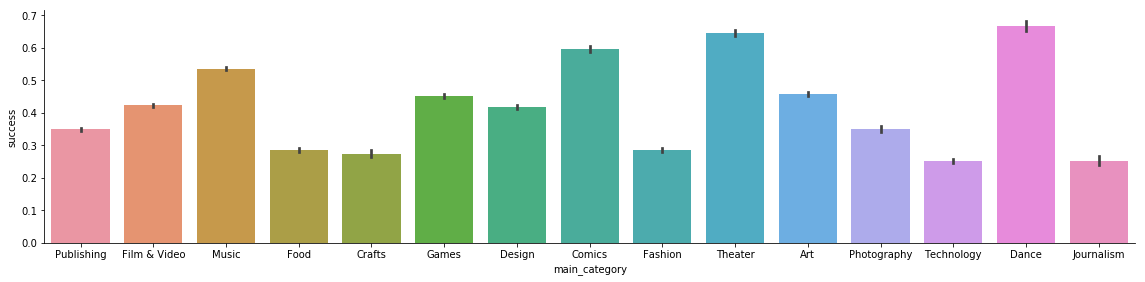

In [14]:
sns.factorplot(x='main_category',y='success',kind='bar', data=ks,aspect=4)

Now that we've seen how the various categories perform in different countries, let's see if some deeper analysis with machine learning  can yield more insights about kickstarter winners.
We will prepare the dataset for further analysis and then create additional sets for each country. By looking at a heatmap of the correlation matrix we see that backers and usd_pledged_real are highly correlated so we will drop pledges.

In [15]:
dumks = pd.get_dummies(ks, columns=['main_category','DurationBin'])
dumks.drop(['ID','name','category','deadline','launched','duration'],axis=1,inplace=True)

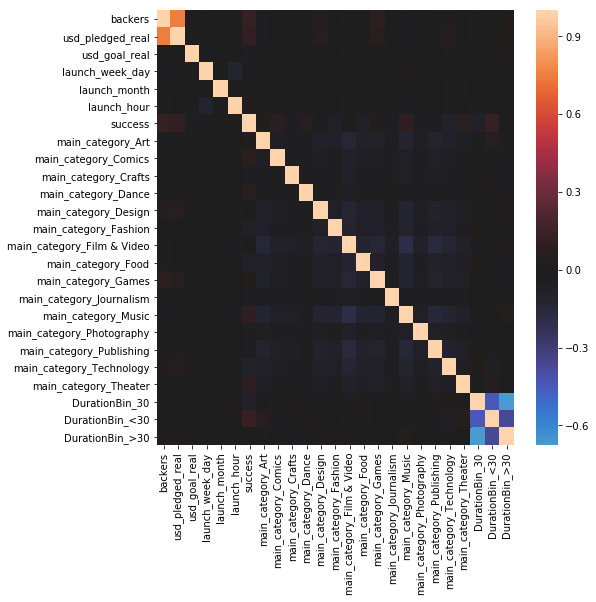

In [16]:
matplotlib.pyplot.figure(figsize=(8,8))
sns.heatmap(dumks.corr(),center=0)

# Logistic Regression

We'll start with a logistic regression to understand which main_category variables have the greatest impact on success at the country level.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import statsmodels.api as sm

In [18]:
us_log = dumks[dumks.country == 'US'].drop(['usd_pledged_real','country'],axis=1)
gb_log = dumks[dumks.country == 'GB'].drop(['usd_pledged_real','country'],axis=1)
ca_log = dumks[dumks.country == 'CA'].drop(['usd_pledged_real','country'],axis=1)

### United States

In [19]:
# define X and Y for US set
Xu = us_log.drop('success', axis=1)
Yu = us_log.success
Xu_train, Xu_test, Yu_train, Yu_test = train_test_split(Xu,Yu,
                                    test_size=.3,random_state=0)

In [20]:
# train the logistic regression for US set
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(Xu_train,Yu_train)
predUS = logistic.predict(Xu_test)
print("***********")
print("accuracy_score:", sk.metrics.accuracy_score(Yu_test, predUS, normalize=True))
print("classification_report:")
print(sk.metrics.classification_report(Yu_test, predUS))
print("confusion_matrix:")
print(sk.metrics.confusion_matrix(Yu_test, predUS))

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

***********
('accuracy_score:', 0.90478012447709422)
classification_report:
             precision    recall  f1-score   support

          0       0.89      0.95      0.92     45678
          1       0.92      0.84      0.88     32730

avg / total       0.91      0.90      0.90     78408

confusion_matrix:
[[43399  2279]
 [ 5187 27543]]


In [21]:
Xu = sm.add_constant(Xu_train)
USmodel = sm.OLS(Yu_train, Xu).fit()
USmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                success   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     696.9
Date:                Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:51:09   Log-Likelihood:            -1.2328e+05
No. Observations:              182950   AIC:                         2.466e+05
Df Residuals:                  182928   BIC:                         2.468e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.3170      0.003    113.491      0.000       0.312       0.322
backers                     5.462e-05   1.04e-06     52.454      0.000    5.26e-05    5.67e-05
usd_goal_real              -1.167e-08   1.19e-09     -9.772      0.000    -1.4e-08   -9.33e-09
launch_week_day               -0.0054      0.001     -8.170      0.000      -0.007      -0.004
launch_month                  -0.0010      0.000     -3.085      0.002      -0.002      -0.000
launch_hour                    0.0010      0.000      7.285      0.000       0.001       0.001
main_category_Art              0.0617      0.004     15.529      0.000       0.054       0.069
main_category_Comics           0.1942      0.006     32.071      0.000       0.182       0.206
main_category_Crafts          -0.1160      0.007    -16.501      0.000      -0.130      -0.102
main_category_Dance            0.2735      0.010     28.376      0.000       0.255       0.292
main_category_Design           0.0146      0.004      3.519      0.000       0.006       0.023
main_category_Fashion         -0.1119      0.005    -24.074      0.000      -0.121      -0.103
main_category_Film & Video     0.0259      0.003      9.065      0.000       0.020       0.031
main_category_Food            -0.0936      0.004    -22.162      0.000      -0.102      -0.085
main_category_Games            0.0471      0.004     11.713      0.000       0.039       0.055
main_category_Journalism      -0.1306      0.010    -13.544      0.000      -0.149      -0.112
main_category_Music            0.1459      0.003     48.268      0.000       0.140       0.152
main_category_Photography     -0.0473      0.006     -7.394      0.000      -0.060      -0.035
main_category_Publishing      -0.0459      0.003    -13.296      0.000      -0.053      -0.039
main_category_Technology      -0.1296      0.004    -30.736      0.000      -0.138      -0.121
main_category_Theater          0.2289      0.006     38.212      0.000       0.217       0.241
DurationBin_30                 0.0464      0.002     26.720      0.000       0.043       0.050
DurationBin_<30                0.2021      0.002     91.701      0.000       0.198       0.206
DurationBin_>30                0.0686      0.002     37.886      0.000       0.065       0.072
==============================================================================
Omnibus:                     3403.541   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5408.862
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                       3.755   Cond. No.                     5.66e+21
==============================================================================

Warnings:
[1] Standard Errors assume that t

From the coefficient results we can tell main_category of Theater, Dance, and Comics has higher positive significant influnce on success rate.

### Great Britain

In [22]:
# define X and Y for GB set
Xg = gb_log.drop('success', axis=1)
Yg = gb_log.success
Xg_train, Xg_test, Yg_train, Yg_test = train_test_split(Xg,Yg,
                                    test_size=.3,random_state=0)

In [23]:
# train the logistic regression for GB set
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(Xg_train,Yg_train)
predGB = logistic.predict(Xg_test)
print("***********")
print("accuracy_score:", sk.metrics.accuracy_score(Yg_test, predGB, normalize=True))
print("classification_report:")
print(sk.metrics.classification_report(Yg_test, predGB))
print("confusion_matrix:")
print(sk.metrics.confusion_matrix(Yg_test, predGB))

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

***********
('accuracy_score:', 0.89950203712086918)
classification_report:
             precision    recall  f1-score   support

          0       0.89      0.95      0.92      5214
          1       0.92      0.83      0.87      3622

avg / total       0.90      0.90      0.90      8836

confusion_matrix:
[[4938  276]
 [ 612 3010]]


In [24]:
Xg = sm.add_constant(Xg_train)
GBmodel = sm.OLS(Yg_train, Xg).fit()
GBmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                success   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     137.4
Date:                Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:51:10   Log-Likelihood:                -13270.
No. Observations:               20617   AIC:                         2.658e+04
Df Residuals:                   20595   BIC:                         2.676e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.3158      0.009     35.032      0.000       0.298       0.333
backers                        0.0002   7.11e-06     29.158      0.000       0.000       0.000
usd_goal_real              -4.952e-09   2.01e-09     -2.459      0.014    -8.9e-09      -1e-09
launch_week_day               -0.0042      0.002     -2.230      0.026      -0.008      -0.001
launch_month                  -0.0018      0.001     -1.898      0.058      -0.004    6.02e-05
launch_hour                   -0.0002      0.001     -0.462      0.644      -0.001       0.001
main_category_Art              0.0545      0.011      4.843      0.000       0.032       0.077
main_category_Comics           0.2578      0.019     13.882      0.000       0.221       0.294
main_category_Crafts          -0.1076      0.019     -5.647      0.000      -0.145      -0.070
main_category_Dance            0.2343      0.031      7.450      0.000       0.173       0.296
main_category_Design           0.0408      0.012      3.515      0.000       0.018       0.064
main_category_Fashion         -0.1027      0.012     -8.448      0.000      -0.126      -0.079
main_category_Film & Video     0.0692      0.008      8.348      0.000       0.053       0.085
main_category_Food            -0.1712      0.014    -12.125      0.000      -0.199      -0.144
main_category_Games            0.0085      0.010      0.844      0.399      -0.011       0.028
main_category_Journalism      -0.1351      0.027     -4.997      0.000      -0.188      -0.082
main_category_Music            0.1000      0.011      9.017      0.000       0.078       0.122
main_category_Photography     -0.0447      0.016     -2.721      0.007      -0.077      -0.013
main_category_Publishing      -0.0145      0.010     -1.385      0.166      -0.035       0.006
main_category_Technology      -0.1840      0.011    -16.627      0.000      -0.206      -0.162
main_category_Theater          0.3104      0.014     22.662      0.000       0.284       0.337
DurationBin_30                 0.0427      0.005      8.473      0.000       0.033       0.053
DurationBin_<30                0.2089      0.006     34.281      0.000       0.197       0.221
DurationBin_>30                0.0642      0.006     11.059      0.000       0.053       0.076
==============================================================================
Omnibus:                      428.045   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              793.589
Skew:                           0.150   Prob(JB):                    4.72e-173
Kurtosis:                       3.913   Cond. No.                     2.12e+22
==============================================================================

Warnings:
[1] Standard Errors assume that t

From the coefficient results we can tell main_category of Theater, Dance, and Comics has higher positive significant influnce on success rate.

### Canada

In [25]:
# define X and Y for CA set
Xc = ca_log.drop('success', axis=1)
Yc = ca_log.success
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc,Yc,
                                    test_size=.3,random_state=0)

In [26]:
# train the logistic regression for CA set
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(Xc_train,Yc_train)
predCA = logistic.predict(Xc_test)
print("***********")
print("accuracy_score:", sk.metrics.accuracy_score(Yc_test, predCA, normalize=True))
print("classification_report:")
print(sk.metrics.classification_report(Yc_test, predCA))
print("confusion_matrix:")
print(sk.metrics.confusion_matrix(Yc_test, predCA))

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

***********
('accuracy_score:', 0.9129614659121531)
classification_report:
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      2463
          1       0.90      0.83      0.86      1248

avg / total       0.91      0.91      0.91      3711

confusion_matrix:
[[2354  109]
 [ 214 1034]]


In [27]:
Xc = sm.add_constant(Xc_train)
CAmodel = sm.OLS(Yc_train, Xc).fit()
CAmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                success   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     49.18
Date:                Tue, 20 Mar 2018   Prob (F-statistic):          2.72e-193
Time:                        12:51:10   Log-Likelihood:                -5285.4
No. Observations:                8659   AIC:                         1.061e+04
Df Residuals:                    8637   BIC:                         1.077e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2513      0.012     20.335      0.000       0.227       0.276
backers                        0.0003   1.06e-05     23.627      0.000       0.000       0.000
usd_goal_real              -1.041e-08   4.91e-09     -2.121      0.034      -2e-08   -7.88e-10
launch_week_day               -0.0040      0.003     -1.410      0.159      -0.010       0.002
launch_month                   0.0015      0.001      1.035      0.301      -0.001       0.004
launch_hour                    0.0002      0.001      0.361      0.718      -0.001       0.001
main_category_Art              0.0092      0.018      0.515      0.606      -0.026       0.044
main_category_Comics           0.2709      0.024     11.259      0.000       0.224       0.318
main_category_Crafts          -0.0346      0.028     -1.250      0.211      -0.089       0.020
main_category_Dance            0.0914      0.056      1.629      0.103      -0.019       0.201
main_category_Design           0.0300      0.016      1.836      0.066      -0.002       0.062
main_category_Fashion          0.0031      0.018      0.175      0.861      -0.032       0.038
main_category_Film & Video     0.0118      0.014      0.815      0.415      -0.017       0.040
main_category_Food            -0.1179      0.018     -6.464      0.000      -0.154      -0.082
main_category_Games           -0.0480      0.015     -3.242      0.001      -0.077      -0.019
main_category_Journalism      -0.1176      0.038     -3.101      0.002      -0.192      -0.043
main_category_Music            0.1298      0.017      7.686      0.000       0.097       0.163
main_category_Photography     -0.0424      0.028     -1.503      0.133      -0.098       0.013
main_category_Publishing      -0.0234      0.015     -1.530      0.126      -0.053       0.007
main_category_Technology      -0.1265      0.014     -8.790      0.000      -0.155      -0.098
main_category_Theater          0.2154      0.039      5.477      0.000       0.138       0.292
DurationBin_30                 0.0452      0.007      6.054      0.000       0.031       0.060
DurationBin_<30                0.1583      0.010     15.570      0.000       0.138       0.178
DurationBin_>30                0.0479      0.008      6.058      0.000       0.032       0.063
==============================================================================
Omnibus:                     1338.772   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              793.669
Skew:                           0.612   Prob(JB):                    4.54e-173
Kurtosis:                       2.162   Cond. No.                     1.05e+22
==============================================================================

Warnings:
[1] Standard Errors assume that t

From the coefficient results we can tell main_category of Theater and Comics has higher positive significant influnce on success rate.

## Finding #1

The results shows that the success rate of different main categories varies between companies based in different countries. <ul>
 <li>Companies that are based in the US, the success rate of 'Music', 'Food', 'Games', 'Art', 'Technology', 'Dance', and 'Journalism' are higher than the other two countries. 
 <li>Companies that are based in Great Britain, the success rate of 'Publishing', 'Film&Video', 'Design', 'Comics', 'Theater', and 'Photography' are higher than the other two countries.
 <li>Companies that are based in Canada, the success rate of 'Crafts', and 'Fashion' are higher than the other two countries. </ul>
<ul>
</ul>
Among those with success rate higher than 0.5, some highlights will be US companies in Music category, Great Britain companies in Comics category, Great Britain companies in Theater category, and US companies in Dance category.

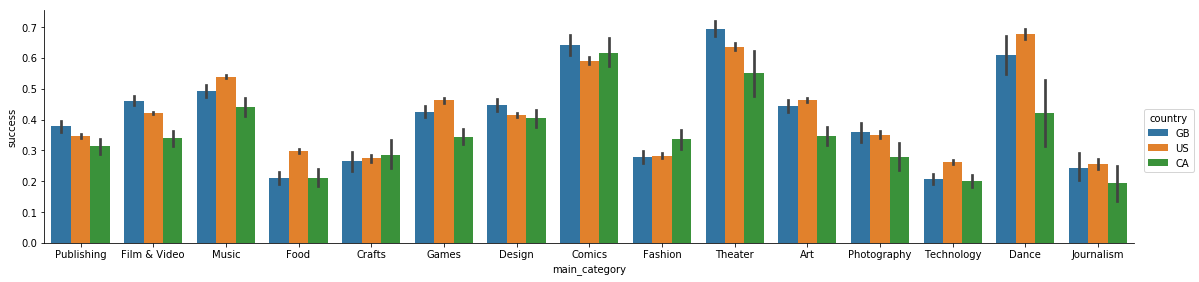

In [28]:
sns.factorplot(x='main_category',y='success',kind='bar', hue='country',data=ks,aspect=4)

## Managerial Insights #1

As managerial insights for the investors, based on the findings above, you should invest in the following types of companies, which have higher success rate on the kickstarter platform:
<li>US companies in Music category
<li>Great Britain companies in Comics category
<li>Great Britain companies in Theater category
<li>US companies in Dance category

# Decision Tree Regression

Now we'll use a decision tree regression to see which variables best predict the likelihood of campaign success.

In [29]:
us_tree = dumks[dumks.country == 'US'].drop(['usd_pledged_real','country'],axis=1)
gb_tree = dumks[dumks.country == 'GB'].drop(['usd_pledged_real','country'],axis=1)
ca_tree = dumks[dumks.country == 'CA'].drop(['usd_pledged_real','country'],axis=1)

### United States

In [30]:
# define X and Y for US set
Xu = us_tree.drop('success', axis=1)
Yu = us_tree.success
dt=tree.DecisionTreeClassifier(max_depth=2)
dt.fit(Xu,Yu)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

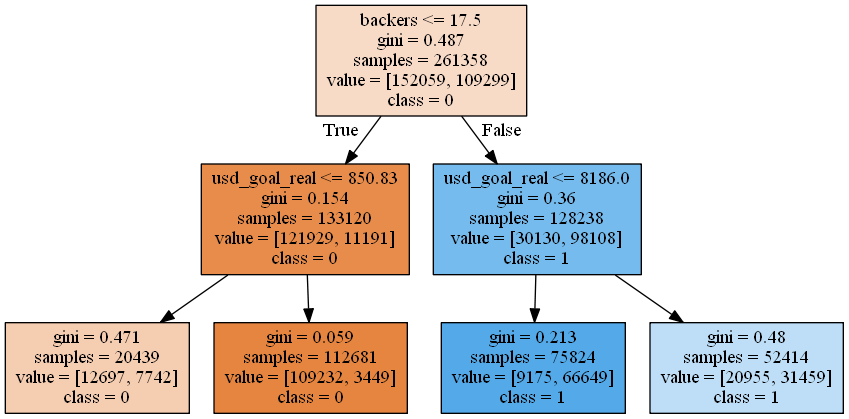

In [31]:
dt_feature_names = list(Xu.columns)
dt_target_names = np.array(Yu.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### Great Britain

In [32]:
# define X and Y for GB set
Xg = gb_tree.drop('success', axis=1)
Yg = gb_tree.success
dt=tree.DecisionTreeClassifier(max_depth=2)
dt.fit(Xg,Yg)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

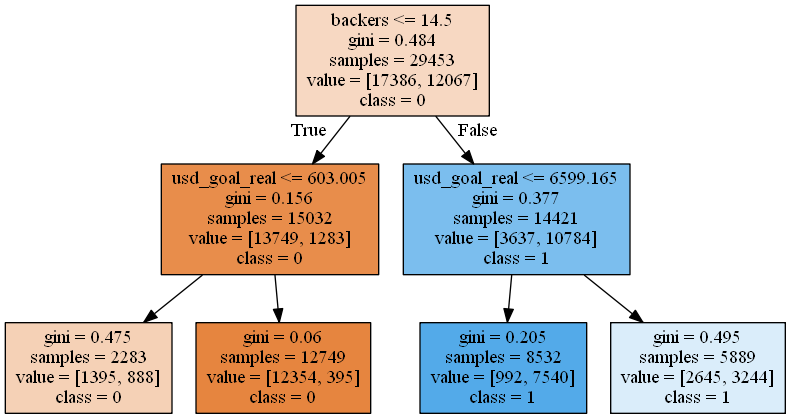

In [33]:
dt_feature_names = list(Xg.columns)
dt_target_names = np.array(Yg.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### Canada

In [34]:
# define X and Y for CA set
Xc = ca_tree.drop('success', axis=1)
Yc = ca_tree.success
dt=tree.DecisionTreeClassifier(max_depth=2)
dt.fit(Xc,Yc)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

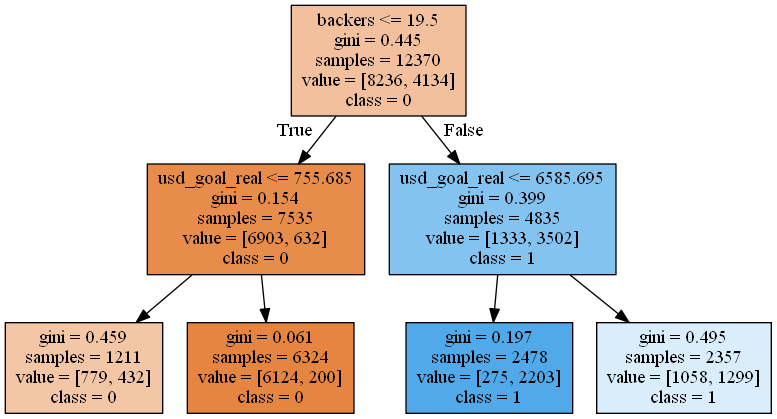

In [35]:
dt_feature_names = list(Xc.columns)
dt_target_names = np.array(Yc.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### Verifying with Logisitic Regression

Our previous logistic regression showed accuracy rates of around 90% across all three countries with the backers variable included. Let's see how accurate the predictions are when backers aren't included.

In [36]:
# define X and Y for whole dataset
KSreg = dumks.drop(['country','usd_pledged_real'],axis=1)
Xk1 = KSreg.drop(['success','backers'], axis=1)
Yk1 = KSreg.success
Xk1_train, Xk1_test, Yk1_train, Yk1_test = train_test_split(Xk1,Yk1,
                                    test_size=.3,random_state=0)

In [37]:
# train the logistic regression for All
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(Xk1_train,Yk1_train)
predKS1 = logistic.predict(Xk1_test)
print("***********")
print("accuracy_score:", sk.metrics.accuracy_score(Yk1_test, predKS1, normalize=True))
print("classification_report:")
print(sk.metrics.classification_report(Yk1_test, predKS1))
print("confusion_matrix:")
print(sk.metrics.confusion_matrix(Yk1_test, predKS1))

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

***********
('accuracy_score:', 0.58800505744598974)
classification_report:
             precision    recall  f1-score   support

          0       0.59      1.00      0.74     53482
          1       0.00      0.00      0.00     37473

avg / total       0.35      0.59      0.44     90955

confusion_matrix:
[[53482     0]
 [37473     0]]


We see that without the backers variable, the model just guesses that all campaigns fail.

## Finding #2

According to the decision tree, the number of backers and the fundraising goal of a project are the strongest indicators of whether or not it will succeed. Projects with many backers and a smaller goal amount are more likely to succeed. Overall, these predictors are quite effective. However, they don't hold true when comparing fashion and theater categories.

Fashion has a significantly lower success rate than theater despite better stats in key indicators.

In [39]:
df2=ks.copy()
df2=df2[(df2.main_category=='Fashion')|(df2.main_category=='Theater')]

Projects in the two categories on average set similar goals.

main_category
Fashion             21,147.732
Theater             20,763.406
Name: usd_goal_real, dtype: float64

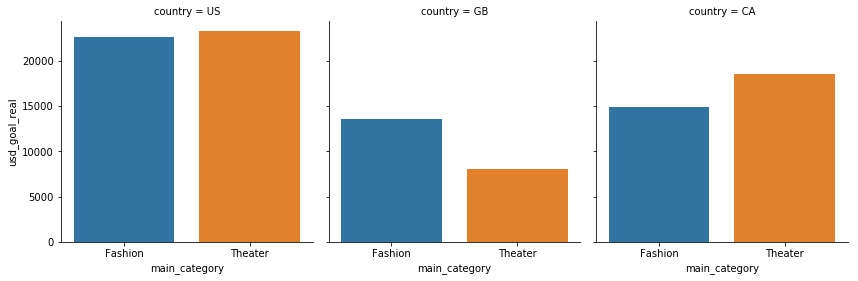

In [40]:
df2.groupby('main_category').usd_goal_real.mean().sort_values(ascending=False)
sns.factorplot(x='main_category',y='usd_goal_real', col='country', data=df2,kind='bar',ci=None)

Fashion projects typically have more backers, which should be a positive thing.

main_category
Fashion                 70.064
Theater                 49.906
Name: backers, dtype: float64

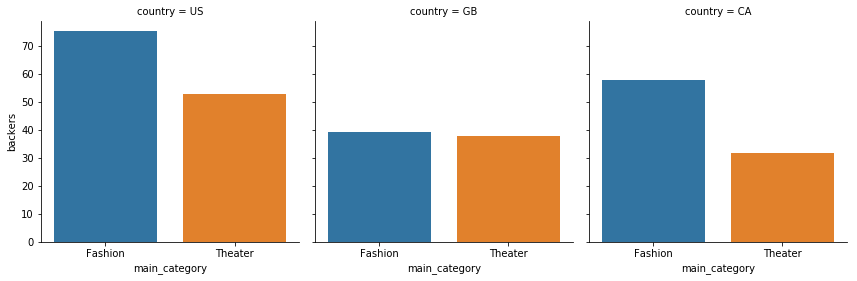

In [41]:
df2.groupby('main_category').backers.mean().sort_values(ascending=False)
sns.factorplot(x='main_category',y='backers',col='country',data=df2,kind='bar',ci=None)

However, theater projects have a success rate more than twice that of fashion projects.

main_category
Theater                  0.645
Fashion                  0.286
Name: success, dtype: float64

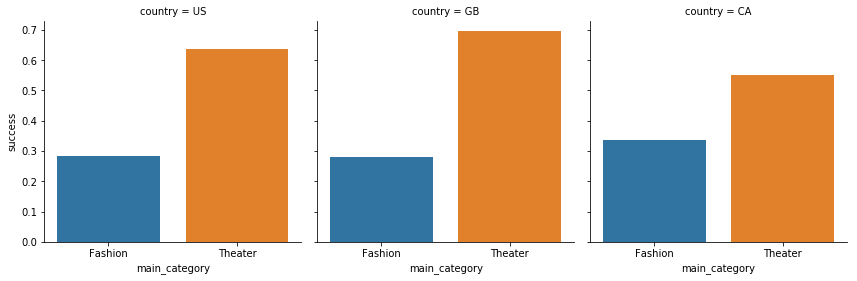

In [42]:
df2.groupby('main_category').success.mean().sort_values(ascending=False)
sns.factorplot(x='main_category',y='success', col='country',data=df2,kind='bar',ci=None)

## Managerial Insights #2

There are a variety of reasons that could explain why this occurs. Perhaps the fashion projects need to do a better job of describing and advertising their products. It could also be the case that the rewards are not enticing enough to convince backers that are unsure about investing. These are areas the project owner could look to improve on. Receiving better information or rewards could push investors to pledge more money, leading to a successful project. Attracting backers is not the issue, rather it is finding a way to get the backers to donate larger amounts.

# Lasso Regression

We've previously seen that the number of backers supporting a campaign is the clearest predicter of whether that campaign is successful or not. So what to do if you are considering launching a new kickstarter campaign? How can you maximize the odds for success? Which factors of a campaign bring in the most backers?

In [43]:
dumks = pd.get_dummies(ks, columns=['main_category','launch_week_day','launch_hour','launch_month'])
dumks.drop(['ID','name','category','deadline','launched','usd_pledged_real','DurationBin'],axis=1,inplace=True)

In [44]:
KSreg = dumks.drop(['country'],axis=1)
USreg = dumks[dumks.country == 'US'].drop(['country'],axis=1)
GBreg = dumks[dumks.country == 'GB'].drop(['country'],axis=1)
CAreg = dumks[dumks.country == 'CA'].drop(['country'],axis=1)

In [45]:
# define X for all where Y = backers
Xk2 = KSreg.drop(['success','backers'], axis=1)
Yk2 = KSreg.backers
Xk2_train, Xk2_test, Yk2_train, Yk2_test = train_test_split(Xk2,Yk2,
                                    test_size=.3,random_state=0)

In [46]:
# train the Lasso for All
regLasso = linear_model.Lasso()
regLasso.fit(Xk2,Yk2)
ksL = pd.Series({Xk2.columns[i] : regLasso.coef_[i]
               for i in range(0,len(Xk2.columns))} )
ksL[ksL != 0]

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

duration                                    0.287
launch_hour_0                             -12.919
launch_hour_1                              -8.642
launch_hour_13                             40.630
launch_hour_14                             91.322
launch_hour_15                             92.736
launch_hour_16                             56.665
launch_hour_17                             30.134
launch_hour_18                             20.142
launch_hour_2                              -1.221
launch_hour_22                             -9.785
launch_hour_23                            -20.388
launch_hour_3                              -5.401
launch_hour_4                              -9.254
launch_month_12                           -14.106
launch_month_5                              1.094
launch_week_day_0                          -1.809
launch_week_day_1                           9.898
launch_week_day_2                          59.453
launch_week_day_3                          16.366


### United States

In [47]:
# define X for US set where Y = backers
Xu2 = USreg.drop(['backers','success'], axis=1)
Yu2 = USreg.backers
Xu2_train, Xu2_test, Yu2_train, Yu2_test = train_test_split(Xu2,Yu2,
                                    test_size=.3,random_state=0)

In [48]:
# train the Lasso for US
regLasso = linear_model.Lasso()
regLasso.fit(Xu2,Yu2)
usL = pd.Series({Xu2.columns[i] : regLasso.coef_[i]
               for i in range(0,len(Xu2.columns))} )
usL[usL != 0]

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

duration                                    0.203
launch_hour_0                             -15.222
launch_hour_1                             -15.025
launch_hour_13                             65.483
launch_hour_14                            113.159
launch_hour_15                            109.489
launch_hour_16                             62.779
launch_hour_17                             30.543
launch_hour_18                             20.996
launch_hour_19                              3.201
launch_hour_2                              -6.512
launch_hour_22                             -8.983
launch_hour_23                            -21.188
launch_hour_3                              -9.776
launch_hour_4                             -15.677
launch_month_12                           -12.607
launch_month_5                              1.264
launch_week_day_0                          -2.120
launch_week_day_1                           9.843
launch_week_day_2                          63.918


### Great Britain

In [49]:
# define X for GB set where Y = backers
Xg2 = GBreg.drop(['success','backers'], axis=1)
Yg2 = GBreg.backers
Xg2_train, Xg2_test, Yg2_train, Yg2_test = train_test_split(Xg2,Yg2,
                                    test_size=.3,random_state=0)

In [50]:
# train the Lasso for GB
regLasso = linear_model.Lasso()
regLasso.fit(Xg2,Yg2)
gbL = pd.Series({Xg2.columns[i] : regLasso.coef_[i]
               for i in range(0,len(Xg2.columns))} )
gbL[gbL != 0]

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

duration                                  0.643
launch_hour_0                           -11.529
launch_hour_11                            9.843
launch_hour_16                            3.568
launch_hour_17                           20.615
launch_hour_19                          -11.348
launch_hour_20                           -9.362
launch_hour_21                          -19.535
launch_hour_22                          -23.166
launch_hour_23                          -27.050
launch_hour_9                             1.824
launch_month_10                           2.802
launch_month_11                           5.461
launch_month_12                         -19.327
launch_month_3                           -2.334
launch_month_4                            6.011
launch_month_5                            7.562
launch_month_7                           -1.534
launch_month_8                          -12.915
launch_week_day_2                        20.572
launch_week_day_6                       

### Canada

In [51]:
# define X and Y for CA set with # of Backers as Y
Xc2 = CAreg.drop(['success','backers'], axis=1)
Yc2 = CAreg.backers
Xc2_train, Xc_test, Yc2_train, Yc2_test = train_test_split(Xc2,Yc2,
                                    test_size=.3,random_state=0)

In [52]:
# train the Lasso for CA
regLasso = linear_model.Lasso()
regLasso.fit(Xc2,Yc2)
caL = pd.Series({Xc2.columns[i] : regLasso.coef_[i]
               for i in range(0,len(Xc2.columns))} )
caL[caL != 0]

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

duration                                    0.318
launch_hour_0                              -1.299
launch_hour_13                             19.140
launch_hour_14                             92.511
launch_hour_15                             87.441
launch_hour_16                             31.317
launch_hour_17                             23.625
launch_hour_18                             61.344
launch_hour_22                            -10.307
launch_hour_23                             -9.766
launch_hour_3                             -11.269
launch_hour_5                              -0.430
launch_hour_6                              10.144
launch_month_1                             17.366
launch_month_12                           -14.073
launch_month_4                             -9.932
launch_month_7                             29.553
launch_month_8                             -0.604
launch_week_day_1                          25.487
launch_week_day_2                          24.489


In [53]:
dfL = pd.DataFrame({'KS':ksL,'US':usL,'GB':gbL,'CA':caL}, columns=['KS','US','GB','CA'])
dfL['SUM'] = dfL.sum(axis = 1)
dfL[dfL.SUM != 0]

,KS,US,GB,CA,SUM
duration,0.287,0.203,0.643,0.318,1.452
launch_hour_0,-12.919,-15.222,-11.529,-1.299,-40.969
launch_hour_1,-8.642,-15.025,0.000,-0.000,-23.668
launch_hour_11,0.000,0.000,9.843,0.000,9.843
launch_hour_13,40.630,65.483,0.000,19.140,125.253
launch_hour_14,91.322,113.159,0.000,92.511,296.992
launch_hour_15,92.736,109.489,-0.000,87.441,289.667
launch_hour_16,56.665,62.779,3.568,31.317,154.329
launch_hour_17,30.134,30.543,20.615,23.625,104.917
launch_hour_18,20.142,20.996,-0.000,61.344,102.482


## Finding #3

The amount of a campaigns goal has little to no impact on the number of backers the campaign attracts. This is true across countries. Additionally, the time of day, day of week and even month of the launch can have a surprising affect on the number of backers a campaign attracts. When taking success rates into considerations, Kickstarter is the best suited to raising money for Comics.

## Managerial Insights #3

When considering launching a campaign, realize that the amount of money you want to raise may affect the attainability of your goal (see previous decision tree regressor), but it will not 'turn off' prospective backers from the get go. 

Check list for maximizing backers:
<ul>
<li> Tuesday launch (in any country)
<li> 2-4pm launch time (if in US or Canada)
<li> 5pm alternate launch time (in any country)
<li> July launch in Canada
</ul>

Avoid list for maximizing backers:
<ul>
<li> Saturday launch (in any country)
<li> Midnight launch time (in any country)
<li> December launch (in any country)
<li> August launch in Great Britain
</ul>

Whether kickstarter is really the right place for you to raise capital for you project or not depends on a combination of these findings and what was uncovered in the first finding. While Games, Design, and Technology all get significantly more backers than the other categories, their success rates as a category are low. Comics is the only category that gets a lot of backers and has a high rate of success. Also, while the regression suggests longer campaigns get more backers (which would make sense as they have more opportunity), the DurationBin success rates and the coefficients of the earlier logistic regression show that shorter campaigns are more successful than longer campaigns.

In [54]:
ks.groupby('DurationBin').success.mean()

DurationBin
30                   0.367
<30                  0.540
>30                  0.405
Name: success, dtype: float64

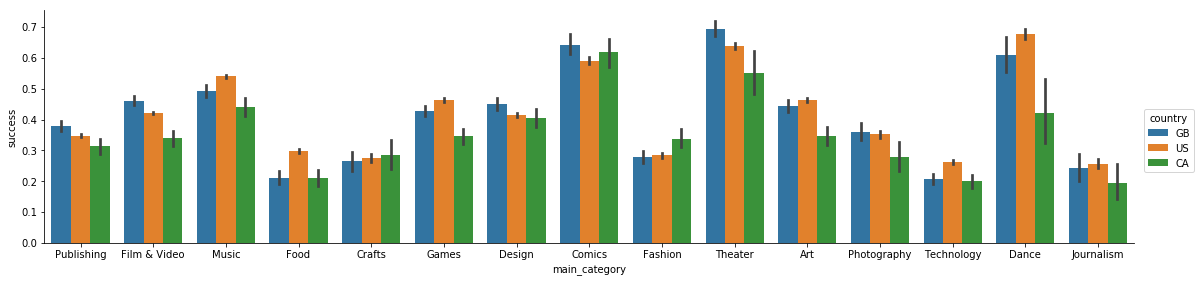

In [55]:
sns.factorplot(x='main_category',y='success',kind='bar', hue='country',data=ks,aspect=4)